In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import sys
from datetime import datetime

In [2]:
sys.path.append(os.path.abspath('..'))

If there's no csv file in data, run the below block

In [3]:
from data.get_raw_data import get_data

final_path = '..\data\eni_stock_data.csv'
ticker = get_data(file_path=final_path)

Getting data for ENI.MI from 2020-01-01 to 2025-06-06...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

CSV file saved to: ..\data\eni_stock_data.csv


If there's already a csv file in data, run this block directly

In [4]:
data = pd.read_csv(final_path, skiprows=3, names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']) # Just to clean column names and first two rows
data.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,9.689637,9.721456,9.594179,9.598330,9175964
1,2020-01-03,9.757427,9.808615,9.677187,9.684105,14319031
2,2020-01-06,9.902689,9.973245,9.794780,9.822449,15677459
3,2020-01-07,9.905454,9.926206,9.845966,9.902687,12574227
4,2020-01-08,9.826598,9.953875,9.826598,9.930356,12108752


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1382 non-null   datetime64[ns]
 1   Close   1382 non-null   float64       
 2   High    1382 non-null   float64       
 3   Low     1382 non-null   float64       
 4   Open    1382 non-null   float64       
 5   Volume  1382 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 64.9 KB


In [6]:
data.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,9.689637,9.721456,9.594179,9.598330,9175964
1,2020-01-03,9.757427,9.808615,9.677187,9.684105,14319031
2,2020-01-06,9.902689,9.973245,9.794780,9.822449,15677459
3,2020-01-07,9.905454,9.926206,9.845966,9.902687,12574227
4,2020-01-08,9.826598,9.953875,9.826598,9.930356,12108752


In [7]:
data.describe()

,Date,Close,High,Low,Open,Volume
count,1382,1382.000000,1382.000000,1382.000000,1382.000000,1.382000e+03
mean,2022-09-15 11:22:29.348770048,10.303161,10.412412,10.200621,10.306782,1.466814e+07
min,2020-01-02 00:00:00,4.357937,4.452722,4.240194,4.352012,4.121347e+06
25%,2021-05-12 06:00:00,7.806536,7.874396,7.733745,7.811462,9.711287e+06
50%,2022-09-14 12:00:00,10.734259,10.881843,10.550369,10.723997,1.251069e+07
75%,2024-01-22 18:00:00,12.988616,13.106795,12.912014,13.009320,1.704929e+07
max,2025-06-05 00:00:00,14.411050,14.489839,14.202166,14.365242,9.624286e+07
std,NaN,2.755192,2.760494,2.753273,2.756537,7.969873e+06


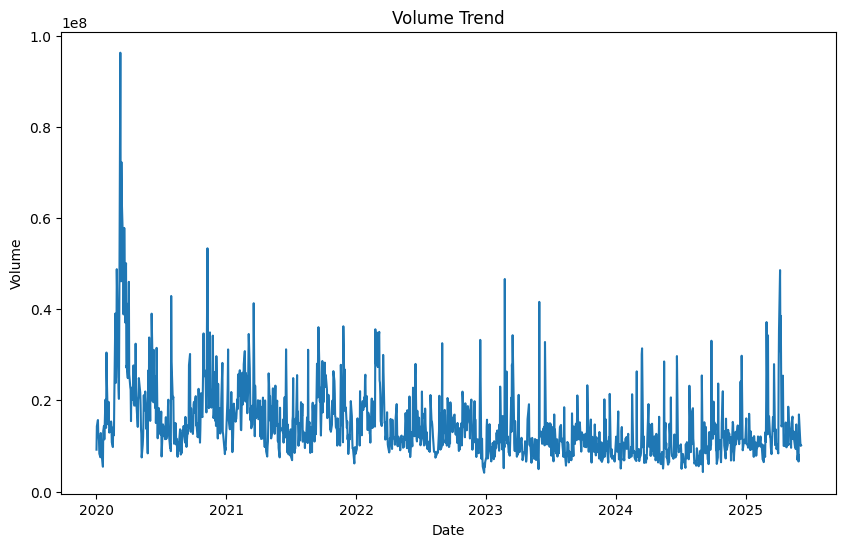

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="Date", y="Volume")
plt.title("Volume Trend")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

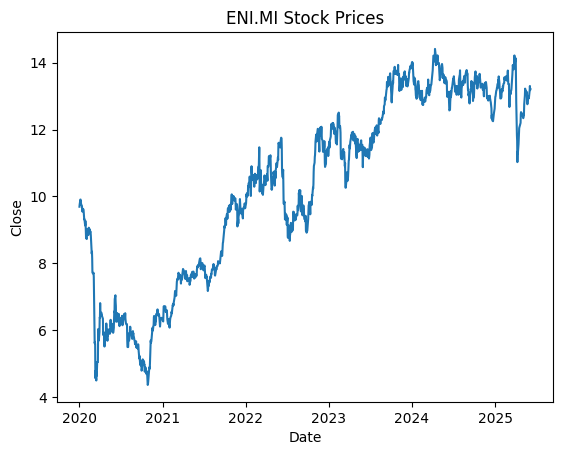

In [9]:
plt.plot(data['Date'],data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title(f"{ticker} Stock Prices")
plt.show()

In [10]:
close_data = data['Close'].values.reshape(-1, 1)

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [12]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [13]:
seq_length = 10  # Number of previous days to use for prediction
X, y = create_sequences(scaled_data, seq_length)

In [14]:
# Train - test split by date
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
from tensorflow import keras
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dense(1))
model.summary

c:\Users\Denis\OneDrive - unige.it\UniGe\Denis\microsoft-lstm\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<bound method Model.summary of <Sequential name=sequential, built=True>>

In [17]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1283 - val_loss: 0.0276
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - val_loss: 7.8486e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 9.1333e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 9.7224e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 8.1123e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 8.2004e-04
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 7.8798e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 7.6370e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 8.2833e-04
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 7.6720e-04
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 7.5707e-04
Epoch 12/100

In [18]:
# Make predictions
test_predict = model.predict(X_test)

# Inverse transform predictions
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [19]:
# Measure the mean squared error
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test[0], test_predict[:, 0])

print("MSE:", rmse)

MSE: 0.036135905326707206


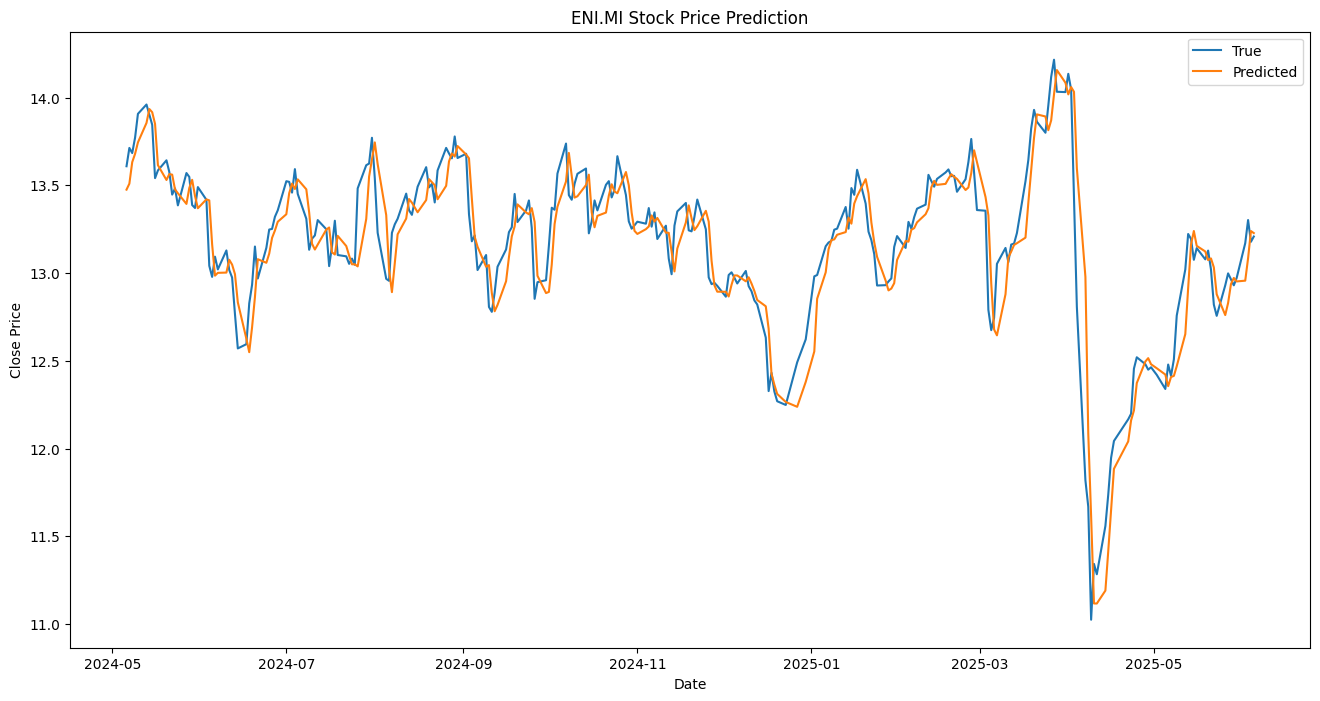

In [20]:
# Plot price prediction vs true value

plt.figure(figsize=(16,8))
plt.plot(data['Date'].values[-len(test_predict):], y_test.T, label='True')
plt.plot(data['Date'].values[-len(test_predict):], test_predict, label='Predicted')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()